# VAE

## 问题

- Q: 为什么 VAE 网络估计的是均值和方差
- A: 因为我们假设了 p(z|x) 是高斯分布，所以只需要求出分布的系数即可

## VAE

VAE 的整体框架如下所示：

<div align=center>
   <img src="./assets/2_VAE_Toy/vae_framework.png" width="80%" >
</div>

### 参考链接

- [Variational Auto-Encoder的原理整理](https://www.cnblogs.com/hblgzsx/articles/18787140)

观测数据为 $x$，Encoder 希望根据观测 $x$ 采样得到隐变量 $z \sim p(z|x)$，接着将其还原为原始数据 $x$。

> 现在的问题是如何求出 $p(z|x)$ 和 $p(x|z)$。

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll, make_circles

### 加载训练数据

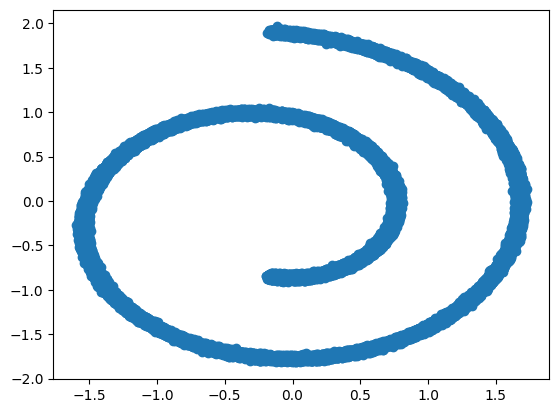

In [2]:
x, _ = make_swiss_roll(n_samples=100_000, noise=0.1)
x = x[:, [0, 2]]
x = (x - x.mean()) / x.std()

plt.scatter(x[:, 0], x[:, 1])

### 将数据转换为 Torch Tensor

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader

In [4]:
X = torch.tensor(x, dtype=torch.float32)
X.shape

torch.Size([100000, 2])

In [5]:
dataset = TensorDataset(X)
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [6]:
for batch_idx, data in enumerate(train_loader):
    print(data[0].shape)
    break

torch.Size([128, 2])


### 构建 VAE 模型

In [7]:
class VAE(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, latent_dim=16):
        super().__init__()
        
        # 编码器
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),
        )
        
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # 解码器
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, input_dim),
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
     
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

### 定义 VAE Loss

In [8]:
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    # 重构损失
    recon_loss = nn.MSELoss(reduction='sum')(recon_x, x)
    # KL散度损失
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + beta*kld_loss

### 开始训练

In [9]:
def train(model, train_loader, optimizer, scheduler, epochs, device, beta=1.0):
    model.train()
    losses = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx, data in enumerate(train_loader):
            data = data[0].to(device)
            optimizer.zero_grad()
            
            # 前向传播
            recon_batch, mu, logvar = model(data)
            loss = vae_loss(recon_batch, data, mu, logvar, beta)
            
            # 反向传播
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        scheduler.step()
        # 记录并打印损失
        avg_loss = epoch_loss / len(train_loader.dataset)
        losses.append(avg_loss)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}')
    
    return losses

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 训练模型
epochs = 30
model = VAE(input_dim=2, hidden_dim=64, latent_dim=16).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.005, total_iters=epochs)
losses = train(model, train_loader, optimizer, scheduler, epochs, device, beta=0.1) # beta 对结果影响很大

Epoch 1/30, Loss: 0.572887
Epoch 2/30, Loss: 0.410795
Epoch 3/30, Loss: 0.396803
Epoch 4/30, Loss: 0.392638
Epoch 5/30, Loss: 0.390379
Epoch 6/30, Loss: 0.387251
Epoch 7/30, Loss: 0.383643
Epoch 8/30, Loss: 0.382859
Epoch 9/30, Loss: 0.380570
Epoch 10/30, Loss: 0.379224
Epoch 11/30, Loss: 0.376701
Epoch 12/30, Loss: 0.377023
Epoch 13/30, Loss: 0.376129
Epoch 14/30, Loss: 0.374544
Epoch 15/30, Loss: 0.373919
Epoch 16/30, Loss: 0.373138
Epoch 17/30, Loss: 0.374134
Epoch 18/30, Loss: 0.372102
Epoch 19/30, Loss: 0.372905
Epoch 20/30, Loss: 0.370595
Epoch 21/30, Loss: 0.371304
Epoch 22/30, Loss: 0.371285
Epoch 23/30, Loss: 0.369954
Epoch 24/30, Loss: 0.370354
Epoch 25/30, Loss: 0.369029
Epoch 26/30, Loss: 0.369477
Epoch 27/30, Loss: 0.371226
Epoch 28/30, Loss: 0.367959
Epoch 29/30, Loss: 0.367542
Epoch 30/30, Loss: 0.367892


### 分析结果

这里我们绘制 loss 的变化曲线和模型预测点并进行绘制

Text(0, 0.5, 'Loss')

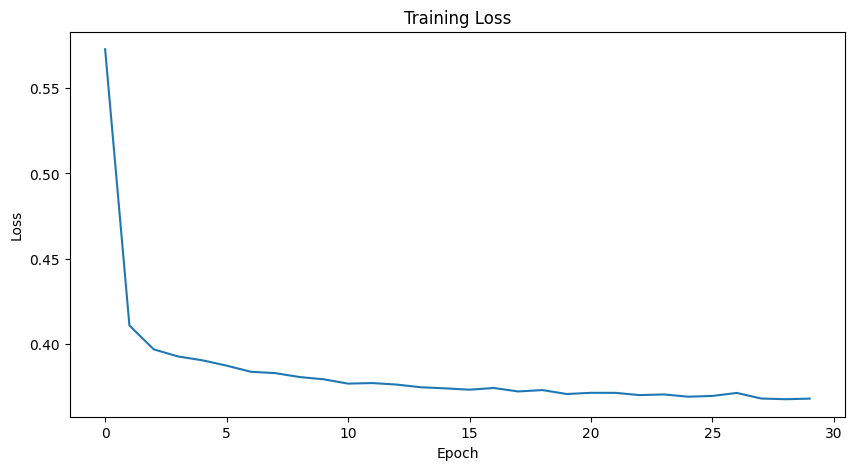

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [12]:
def generate_samples(model, device, n_sample=1_000_000):
    model.eval()
    with torch.no_grad():
        # 从标准正态分布采样
        z = torch.randn(n_sample, 16).to(device) # 这里为什么是 2, 这里是否正确
        samples = model.decode(z).cpu().numpy()
    
    plt.figure(figsize=(8, 6))
    plt.scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.5)
    plt.title(f'Generated Samples')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

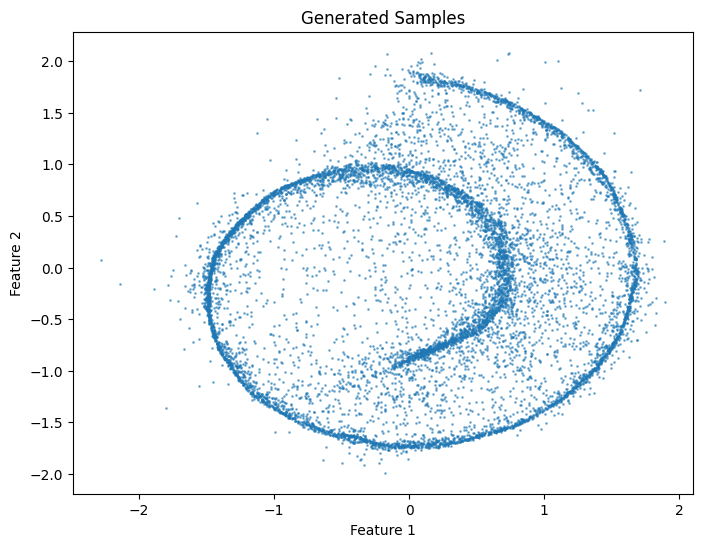

In [13]:
generate_samples(model, device, n_sample=10_000)

### 分析不同 beta 对结果的影响

In [14]:
def generate_samples_to_file(model, beta, device, output_file, n_sample=1_000_000):
    model.eval()
    with torch.no_grad():
        # 从标准正态分布采样
        z = torch.randn(n_sample, 16).to(device) # 这里为什么是 2, 这里是否正确
        samples = model.decode(z).cpu().numpy()
    
    plt.figure(figsize=(8, 6))
    plt.scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.5)
    plt.title(f'Generated Samples Beta={beta}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.savefig(output_file)

Epoch 1/50, Loss: 0.068464
Epoch 2/50, Loss: 0.026129
Epoch 3/50, Loss: 0.022846
Epoch 4/50, Loss: 0.020423
Epoch 5/50, Loss: 0.018813
Epoch 6/50, Loss: 0.017618
Epoch 7/50, Loss: 0.016566
Epoch 8/50, Loss: 0.016505
Epoch 9/50, Loss: 0.016842
Epoch 10/50, Loss: 0.015789
Epoch 11/50, Loss: 0.016277
Epoch 12/50, Loss: 0.016572
Epoch 13/50, Loss: 0.016260
Epoch 14/50, Loss: 0.015424
Epoch 15/50, Loss: 0.016673
Epoch 16/50, Loss: 0.016704
Epoch 17/50, Loss: 0.016211
Epoch 18/50, Loss: 0.015887
Epoch 19/50, Loss: 0.016416
Epoch 20/50, Loss: 0.015421
Epoch 21/50, Loss: 0.015066
Epoch 22/50, Loss: 0.015752
Epoch 23/50, Loss: 0.015753
Epoch 24/50, Loss: 0.016211
Epoch 25/50, Loss: 0.015051
Epoch 26/50, Loss: 0.015276
Epoch 27/50, Loss: 0.015879
Epoch 28/50, Loss: 0.015648
Epoch 29/50, Loss: 0.015396
Epoch 30/50, Loss: 0.016224
Epoch 31/50, Loss: 0.014658
Epoch 32/50, Loss: 0.015062
Epoch 33/50, Loss: 0.016101
Epoch 34/50, Loss: 0.015327
Epoch 35/50, Loss: 0.016371
Epoch 36/50, Loss: 0.015277
E

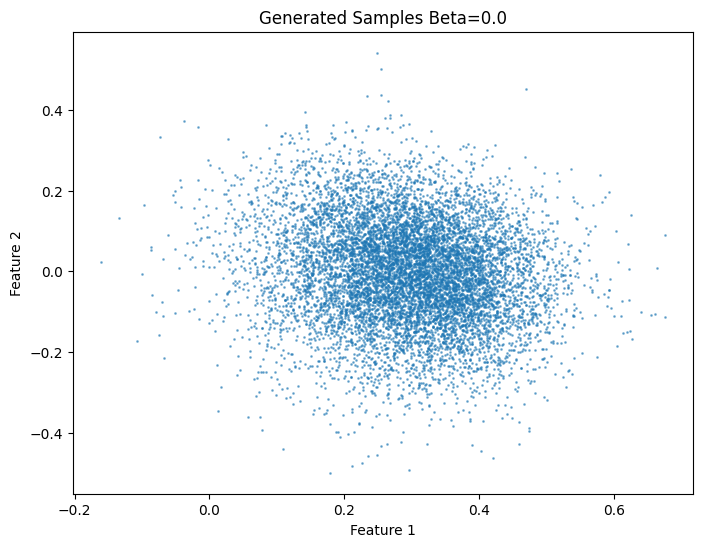

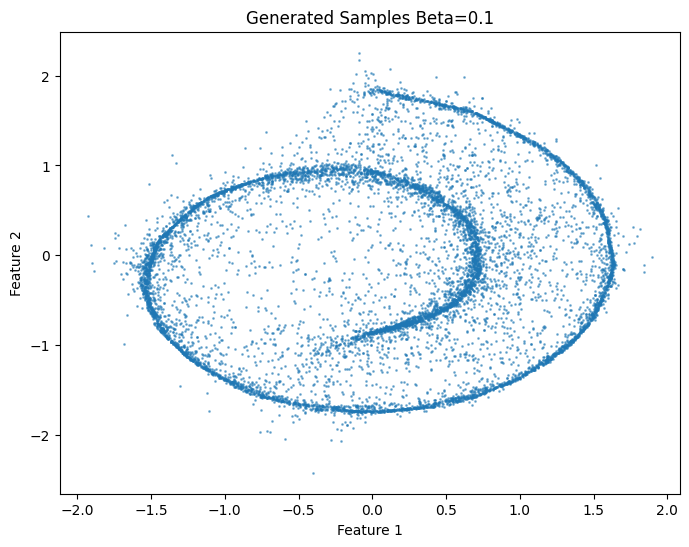

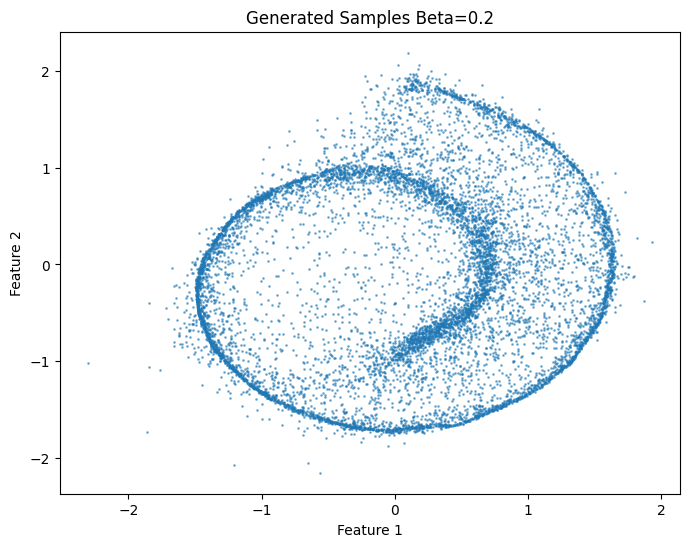

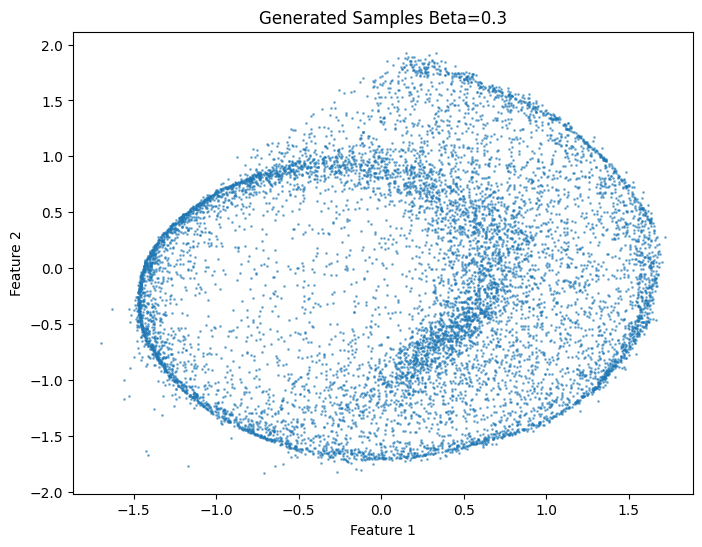

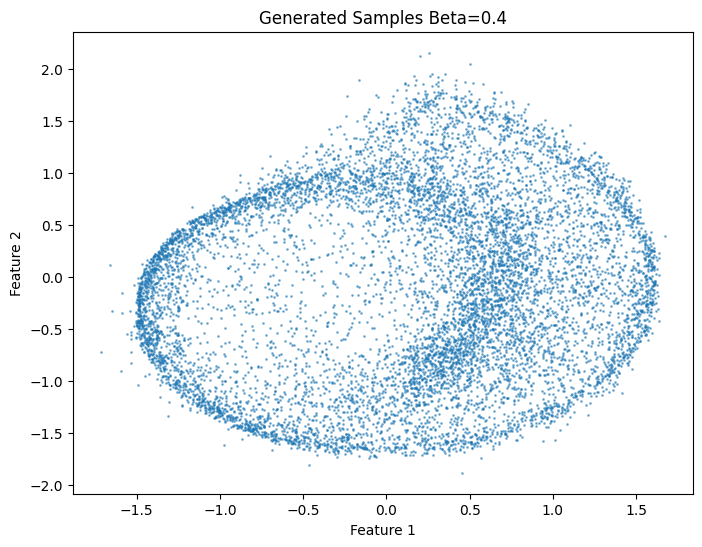

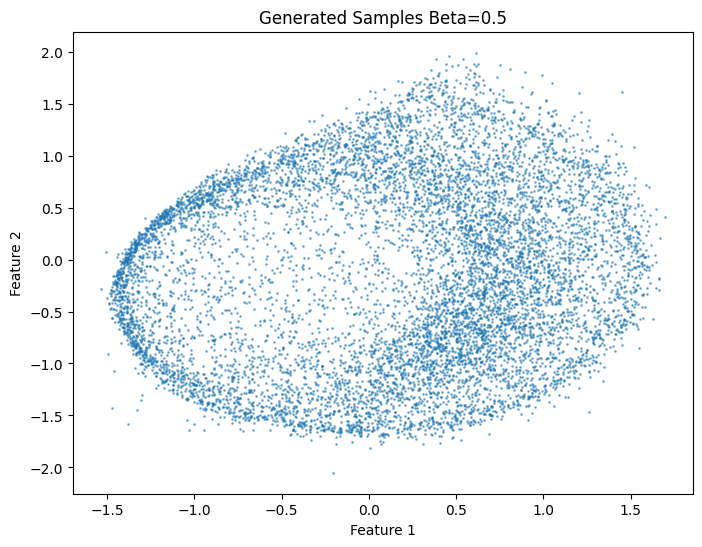

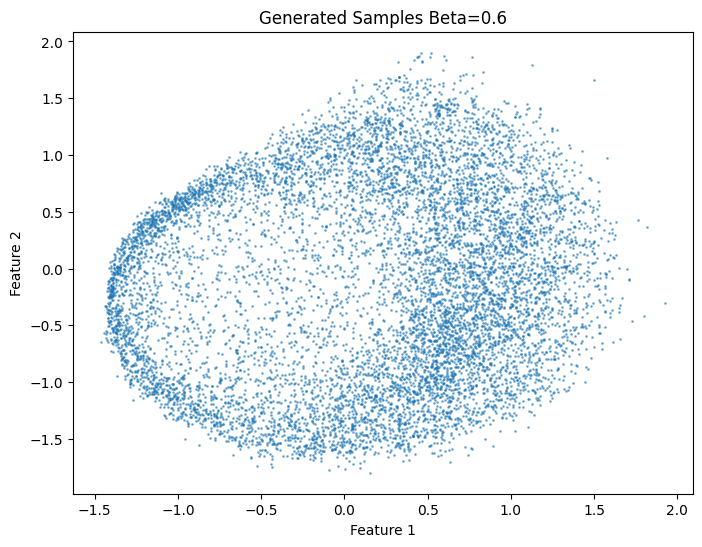

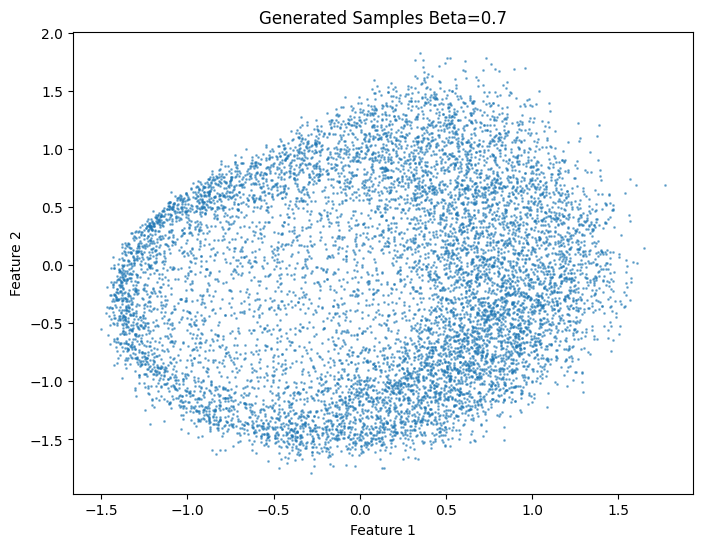

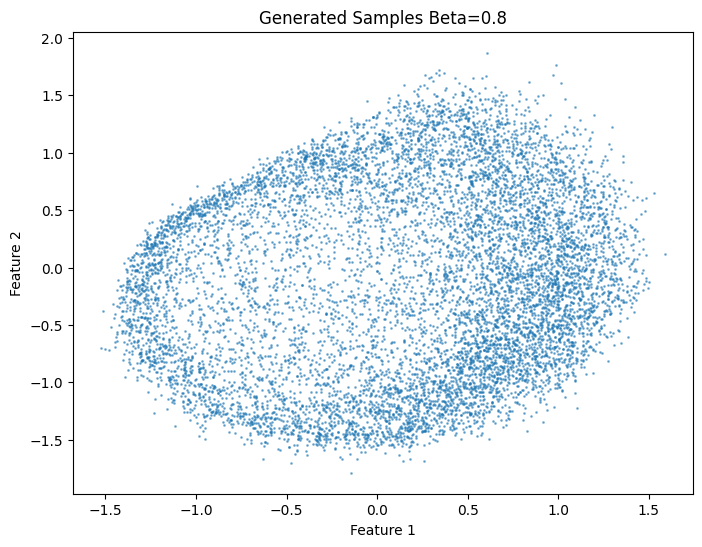

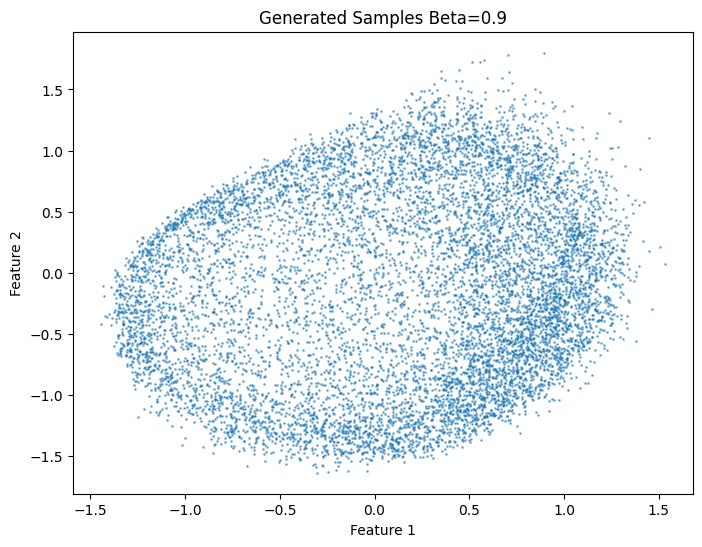

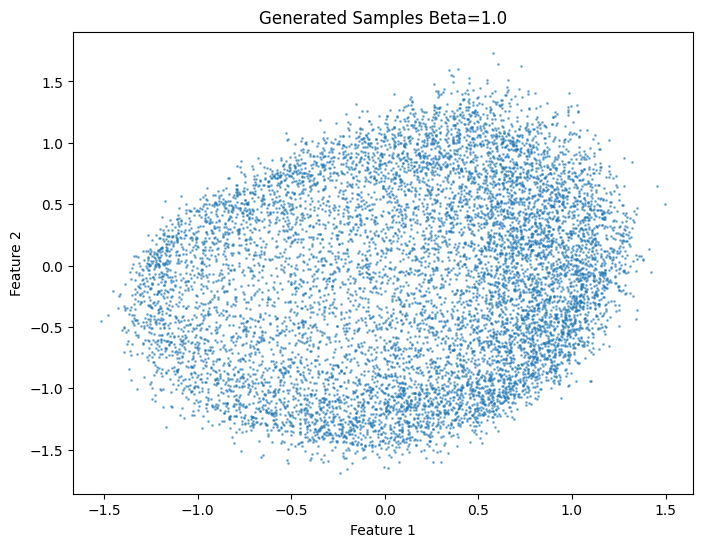

In [15]:
for i in range(0, 11):
    epochs = 50
    _beta = i / 10.0    # 转换为 0.0, 0.1, ..., 1
    model = VAE(input_dim=2, hidden_dim=64, latent_dim=16).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.01, total_iters=epochs)
    losses = train(model, train_loader, optimizer, scheduler, epochs, device, beta=_beta) # beta 对结果影响很大

    # 可视化结果
    generate_samples_to_file(model, _beta, device, output_file=f"./{_beta}.png", n_sample=10_000)